# GA con funciones Python

A tomar en cuenta:

1. El uso de funciones python hace muy eficiente el código en temas de tiempo

2. El único "inconveniente" sería que la función best_fit la entrega en formato: **[<function coeficiente2 at 0x0000018AEB6E7600>, '/', <function ident at 0x0000018AD95FE520>, '+', <function coeficiente2 at 0x0000018AEB6E7600>, '*', <function ident at 0x0000018AD95FE520>, '+', <function coeficiente1 at 0x0000018AEB6E7560>, '**', <function coeficiente1 at 0x0000018AEB6E7560>]**

3. Todavía no encuentro una forma *no manual* de pasar de ese formato a la expresión simbólica de la función

4. Además, si se quiere correr el código, hay que tomar en cuenta que la función final sería algo como: **(((<function coeficiente2 at 0x0000018AEB6E7600> / <function ident at 0x0000018AD95FE520>) + <function coeficiente2 at 0x0000018AEB6E7600>) * <function ident at 0x0000018AD95FE520> + <function coeficiente1 at 0x0000018AEB6E7560>)** <function coeficiente1 at 0x0000018AEB6E7560>**, es decir, hay que ir poniendo manualmente los paréntesis debido a que el código trata las funciones de izquierda a derecha y no como normalmente se haría, es decir, poniéndole prioridad a ciertas operaciones sobre otras. 

5. De tomas formas entrega una función bien fiteada! 

In [1]:
import numpy as np
import random
from sympy import symbols, parse_expr, lambdify, srepr, sympify
import matplotlib.pyplot as plt
import time
x = symbols('x')

import logging
# Configuración básica del registro
logging.basicConfig(level=logging.INFO)

import warnings

# Ignorar todas las advertencias de RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

print(z)

[0.07    0.09    0.12    0.17    0.179   0.199   0.2     0.27    0.28
 0.35    0.352   0.3802  0.4     0.4004  0.4247  0.44    0.44497 0.4783
 0.47    0.48    0.57    0.593   0.6     0.68    0.73    0.75    0.781
 0.8     0.875   0.88    0.9     1.037   1.3     1.363   1.43    1.53
 1.75    1.965   2.34   ]


### Definicion de funciones

In [3]:
class Create_Individual:
    def __init__(self, params, expression = None):
        if expression is None:
            genes = [np.random.choice(params['genes']) for _ in range(0, params['number_of_genes'] + 1, 2)]
            operations = [np.random.choice(params['operaciones']) for _ in range(1, params['number_of_genes'] + 1, 2)]
            self.expression = [valor for par in zip(genes, operations) for valor in par] + [np.random.choice(params['genes'])] #se le suma un gen para que quede una funcion al final/No cambia el numero de cromosomas
        else:
            self.expression = [valor for valor in expression]

    def obtain_expressions(self): #da los cromosomas del individuo
        return self.expression

La composicion compone las cosas de izquierda a derecha

In [4]:
class Create_Generation:
    def __init__(self, ind_parameters, pop_parameters, fitness_function, expression = None):
        #Crea una poblacion inicial
        self.size = pop_parameters['size'] # Tamaño poblacion
        self.initial_poblation = ind_parameters['genes']
        self.initial_operation = ind_parameters['operaciones']
        self.mutation_rate = pop_parameters['mutation_rate']
        self.selection_rate = pop_parameters['selection _rate']
        self.fitness_function = fitness_function 

        if expression == None:
            self.individuals = [Create_Individual(ind_parameters)  for _ in range(self.size)]
        else:
            self.individuals = [Create_Individual(ind_parameters, expression = expression[i]) for i in range(len(expression))]

    #def evaluar_expresion(self, x, expresion):
     #   resultado = expresion[0](x)
      #  for i in range(1, len(expresion), 2):
       #     operador = expresion[i]
        #    funcion = expresion[i+1]
            
         #   if operador == '+':
              #  resultado = resultado + funcion(x)
          #  elif operador == '-':
               # resultado = resultado - funcion(x)
           # elif operador == '*':
                #resultado = resultado * funcion(x)
          #  elif operador == '/':
                #resultado = resultado / funcion(x)
          #  elif operador == '**':
           #     resultado = resultado ** funcion(x)
       # return resultado
    

    def evaluar_expresion(self, x, expresion):
        resultado = expresion[0](x)

        i = 1
        while i < len(expresion):
            operador = expresion[i]
            funcion = expresion[i + 1]

            if operador == '+':
                resultado = resultado + funcion(x)
            elif operador == '-':
                resultado = resultado - funcion(x)
            elif operador == '*':
                resultado = resultado * funcion(x)
            elif operador == '/':
                resultado = resultado / funcion(x)
            elif operador == '**':
                resultado = resultado ** funcion(x)
            elif operador == 'comp':
                resultado = funcion(resultado)
            
            i += 2

        return resultado

    def child(self, parent, parent2, crossover_point):
        kid = []
        if len(parent) == 1 and len(parent2) == 1:
            kid = parent
        elif len(parent) == 1:
            kid[:0] = parent
            kid[1:] = parent2[1:]
        elif len(parent2) == 1:
            kid[:0] = parent2
            kid[1:] = parent[1:]
        else:                
            kid[:crossover_point] = parent[:crossover_point]
            kid[crossover_point:] = parent2[crossover_point:]
        return kid

    def get_parents(self, poblacion) -> np.array: # pares son expresiones e impares son operaciones
        n_parents = int((self.selection_rate)/100 * len(poblacion))
        parents = []
        for expresion in poblacion:
            parents.append(expresion.obtain_expressions())
        parents_evaluate = [self.evaluar_expresion(z, expresion) for expresion in parents]
        Chi = [self.fitness_function(function) for function in parents_evaluate]
        Minor_Chi = min(Chi)
        sorted_parents = [x for _, x in sorted(zip(Chi, parents), key=lambda pair: pair[0])]
        selected_parents = sorted_parents[:n_parents]
        non_selectec_parents = sorted_parents[n_parents:]
        r1 = random.random()
        r2 = random.random()
        no_apto = random.choice(non_selectec_parents)
        no_apto_2 = random.choice(non_selectec_parents)
        no_apto_3 = random.choice(non_selectec_parents)
        if r1>r2:
            Selected_parents = selected_parents + [no_apto] + [no_apto_2] + [no_apto_3]
        else:
            Selected_parents = selected_parents
        return Selected_parents, Minor_Chi
    
    def crossover(self, parents: np.array) -> np.array:
        offspring = []
        for parent in parents:
            crossover_point = random.choice(range(1, len(parents))) #se elige un numero entre 1 y el penultimo cormosoma para que siempre haya crossover
            parent2 = random.choice(parents)
            parent3 = random.choice(parents)
            parent4 = random.choice(parents)
            parent5 = random.choice(parents)
            parent6 = random.choice(parents)
            kid = self.child(parent, parent2, crossover_point)
            kid2 = self.child(parent, parent3, crossover_point)
            kid3 = self.child(parent, parent4, crossover_point)
            kid4 = self.child(parent, parent5, crossover_point)
            kid5 = self.child(parent, parent6, crossover_point)
            offspring.append(kid)
            offspring.append(kid2)
            offspring.append(kid3)
            offspring.append(kid4)
            offspring.append(kid5)

        return offspring
    
    def mutate(self, offspring_crossover) -> np.array: # contras: a veces se pude mutar el mismo individuo
        num_mutations = int(len(offspring_crossover)*self.mutation_rate/100)
        for num in range(num_mutations):
            idx_mutation = random.choice(range(len(offspring_crossover))) # se elige individuo que se va a mutar
            ind_mutate = offspring_crossover[idx_mutation]
            g = random.choice(range(len(ind_mutate))) #numero de gen que se va a mutar
            if g % 2 == 0 or g==0:
                new_gen = random.choice(self.initial_poblation)
                ind_mutate[g] = new_gen
            else:
                new_gen = random.choice(self.initial_operation)
                ind_mutate[g] = new_gen
        return offspring_crossover

In [5]:
class Evolution:
    def __init__(self, gen_parameter, ind_parameters, pop_params, fitness_function): #gen_parameter = {'selection_rate' : 20, 'mutation_rate' : 10, 'num_generations': 100}
        self.selection_rate = gen_parameter['selection_rate']
        self.mutation_rate = gen_parameter['mutation_rate']
        self.num_generations = gen_parameter['num_generations']
        self.fitness_function = fitness_function
        self.ind_parameters = ind_parameters
        self.pop_params = pop_params

    def Iteracion(self):
        inicio_tiempo = time.time()
        Generations = []
        Chi = []
        for n in range(self.num_generations):
            logging.info(f'Número de la generación: {n}')
            if n == 0: 
                A = Create_Generation(self.ind_parameters, self.pop_params, self.fitness_function)
                initial_poblation = A.individuals
                parents, minor_chi = A.get_parents(initial_poblation)
                Chi.append(minor_chi)
                crossover = A.crossover(parents)
                mutation = A.mutate(crossover)
                Generations.append(mutation)
            else:
                A = Create_Generation(self.ind_parameters, self.pop_params, self.fitness_function, expression = Generations[n-1])
                poblation = A.individuals
                parents, minor_chi = A.get_parents(poblation)
                Chi.append(minor_chi)
                crossover = A.crossover(parents)
                mutation = A.mutate(crossover)
                Generations.append(mutation)
        
        tiempo_transcurrido = time.time() - inicio_tiempo
        logging.info(f"La evolución tomó {tiempo_transcurrido} segundos en ejecutarse.")
        return Generations[-1], Chi

### Primera prueba de evolucion

In [6]:
def ident(x):
    return (x+1)

def expo(x):
    return x**x

def poli2(x):
    return x**2

def poli3(x):
    return x**3

def coeficiente1(x):
    return 2

def coeficiente2(x):
    return 3

def Chi(*x): 
    return np.sum(((H - x)/desv)**2)

Genes = [ident, expo, coeficiente1, coeficiente2]
print(Genes)

[<function ident at 0x0000018AD95FE520>, <function expo at 0x0000018AEB6E74C0>, <function coeficiente1 at 0x0000018AEB6E7560>, <function coeficiente2 at 0x0000018AEB6E7600>]


In [22]:
pop_params = {'size': 20,'selection _rate': 20, 'mutation_rate' : 15}
ind_parameters = {'genes': Genes, 'operaciones': ['+', '-', '*',  '/', '**','comp'], 'number_of_genes': 10}
gen_parameter = {'selection_rate' : 20, 'mutation_rate' : 15, 'num_generations' : 500}

intento1 = Evolution(gen_parameter, ind_parameters, pop_params, Chi)

ultima_generacion, chi = intento1.Iteracion()

INFO:root:Número de la generación: 0
INFO:root:Número de la generación: 1
INFO:root:Número de la generación: 2
INFO:root:Número de la generación: 3
INFO:root:Número de la generación: 4
INFO:root:Número de la generación: 5
INFO:root:Número de la generación: 6
INFO:root:Número de la generación: 7
INFO:root:Número de la generación: 8
INFO:root:Número de la generación: 9
INFO:root:Número de la generación: 10
INFO:root:Número de la generación: 11
INFO:root:Número de la generación: 12
INFO:root:Número de la generación: 13
INFO:root:Número de la generación: 14
INFO:root:Número de la generación: 15
INFO:root:Número de la generación: 16
INFO:root:Número de la generación: 17
INFO:root:Número de la generación: 18
INFO:root:Número de la generación: 19
INFO:root:Número de la generación: 20
INFO:root:Número de la generación: 21
INFO:root:Número de la generación: 22
INFO:root:Número de la generación: 23
INFO:root:Número de la generación: 24
INFO:root:Número de la generación: 25
INFO:root:Número de la

El Chi menor fue: 19.71640668714861


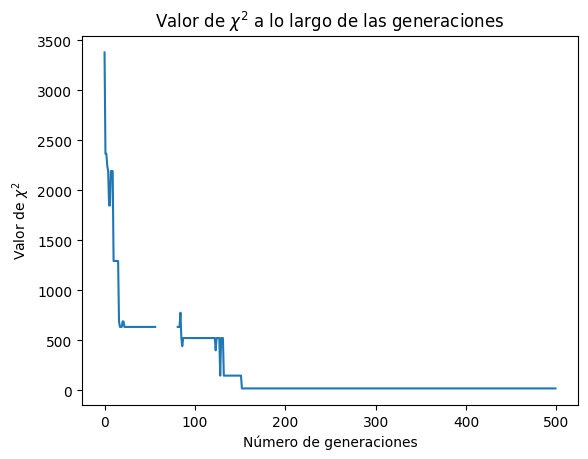

[3377.822693304855, 2365.0911330795516, 2365.0911330795516, 2246.4653379758834, 2191.9047890900324, 1848.5812323719706, 1848.5812323719706, 2191.9047890900324, 2191.9047890900324, 2191.9047890900324, 1293.619405850285, 1293.619405850285, 1293.619405850285, 1293.619405850285, 1293.619405850285, 1293.619405850285, 689.3925553261836, 634.2980226264151, 634.2980226264151, 634.2980226264151, 689.3925553261836, 689.3925553261836, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 634.2980226264151, 63

In [23]:
# Evaluacion de Chi

minor_chi = chi
print('El Chi menor fue: ' + str(min(minor_chi)))
num_generaciones = np.arange(0, len(minor_chi), 1)
plt.plot(num_generaciones, minor_chi)
plt.xlabel('Número de generaciones')
plt.ylabel('Valor de $\chi^2$')
plt.title('Valor de $\chi^2$ a lo largo de las generaciones')
plt.show()

print(minor_chi)

### Best fit encontradas

In [24]:
def evaluar_expresion(z, expresion):
        resultado = expresion[0](z)
        for i in range(1, len(expresion), 2):
            operador = expresion[i]
            funcion = expresion[i+1]
            
            if operador == '+':
                resultado = resultado + funcion(z)
            elif operador == '-':
                resultado = resultado - funcion(z)
            elif operador == '*':
                resultado = resultado * funcion(z)
            elif operador == '/':
                resultado = resultado / funcion(z)
            elif operador == '**':
                resultado = resultado ** funcion(z)
        return resultado

evaluadas = []
for expresion in ultima_generacion:
     evaluadas.append(evaluar_expresion(z, expresion))

def calcular_chi(funcion_evaluada, H, desv):
     return np.sum(((H - funcion_evaluada)/desv)**2)

chi_evaluados = []
for evaluada in evaluadas:
     chi_evaluados.append(calcular_chi(evaluada, H, desv))

print(chi_evaluados)
print(ultima_generacion)

[19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 20581.20885233082, 19.71640668714861, 1763.79096339273, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 2504.8024012721717, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668714861, 19.71640668

In [25]:
def f1(x): 
    return 3*3+x+x**3*3*3

def f2(x):
    return x**3 * 3 / (x+1) * x**2 + 3 * 3

def f3(x):
    return (((3 * 3) + x**2) + (x**3)) * 3 * 3

def f4(x):
    return ((((3*3) * (x+1)) * 2) + 3) * 3

def f5(x):
    return ((((2 + 3) * 3) * 2) * 2 )* (x+1)

def f6(x):
    '''
    chi = 28
    '''
    return (((3 + 3) * 3 )+ (x+1)) * (x+1) * 3

def f7(x):
    '''
    chi = 22
    '''
    return (3**3 + (x+1) + 2) * (x+1) * 2

def f8(x):
    '''
    chi = 19.71640668714861
    Generaciones = 500
    Tiempo = 26.6 s
    '''
    return (((3 / (x+1)) + 3) * (x+1) + 2) ** 2

### Se grafican los datos y la best_fit con menor chi encontrada hasta el momento (fue el último intento)

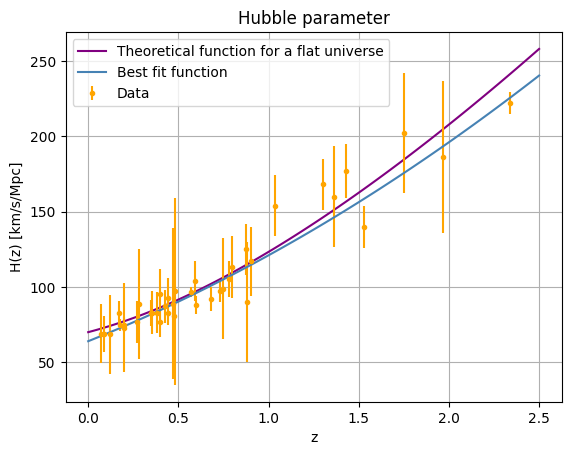

In [26]:
def H_bm(z, Omega_r, Omega_m, Omega_lambda, omega_DE): 
    return H_0*np.sqrt((Omega_r*(1+z)**(3*(1 + 1/3)) + Omega_m*(1+z)**3 + Omega_lambda*(1+z)**(3*(1+omega_DE)) + (1-Omega_r-Omega_m-Omega_lambda)*(1+z)**2))


H_0 = 70
O_r = 8.4*10**(-5)
O_m = 0.3
O_lambda = 0.7 - 8.4*10**(-5)
o_DE = -1
O_0 = [0.5, 1, 1.5]

# Se crea un arreglo de z para la función teórica
z_bu = np.linspace(0, 2.5, 100)

# hub_data_3.txt
H_teorico_plano = H_bm(z_bu,O_r, O_m, O_lambda, o_DE)
H_teorico_cerrado = H_bm(z_bu,O_r, O_m, 0.9*O_lambda, o_DE)
H_teorico_abierto = H_bm(z_bu,O_r, O_m, 1.1*O_lambda, o_DE)


#plt.plot(z_bu, H_teorico_cerrado, label = 'Función teórica para $K = 1$ (cerrado)')
plt.plot(z_bu, H_teorico_plano, label = 'Theoretical function for a flat universe', color = 'purple')
#plt.plot(z_bu, H_teorico_abierto, label = 'Función teórica para $K = -1$ (abierto)')
plt.errorbar(z, H, yerr=desv, fmt='.', label='Data', color = 'orange')
#plt.plot(z, H, '.')
plt.plot(z_bu, f8(z_bu), label= 'Best fit function', color = '#4682B4')
plt.title('Hubble parameter')
plt.xlabel('z')
plt.ylabel('H(z) [km/s/Mpc]')
plt.grid(True)
plt.legend()
plt.show()